In [1]:
%pylab inline

import numpy as np
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Face recognition

The goal of this seminar is to build two simple (anv very similar) face recognition pipelines using **`scikit-learn`** package. Overall, we'd like to explore different representations and see which one works better. 

## Prepare dataset

In [2]:
import scipy.io

image_h, image_w = 32, 32

data = scipy.io.loadmat('faces_data.mat')

X_train = data['train_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_train = data['train_labels'] - 1
X_test = data['test_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_test = data['test_labels'] - 1

n_features = X_train.shape[1]
n_train = len(y_train)
n_test = len(y_test)
n_classes = len(np.unique(y_train))

print('Dataset loaded.')
print('  Image size        : {}x{}'.format(image_h, image_w))
print('  Train images      : {}'.format(n_train))
print('  Test images       : {}'.format(n_test))
print('  Number of classes : {}'.format(n_classes))

Dataset loaded.
  Image size        : 32x32
  Train images      : 280
  Test images       : 120
  Number of classes : 40


Now we are going to plot some samples from the dataset using the provided helper function.

In [3]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='nearest')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

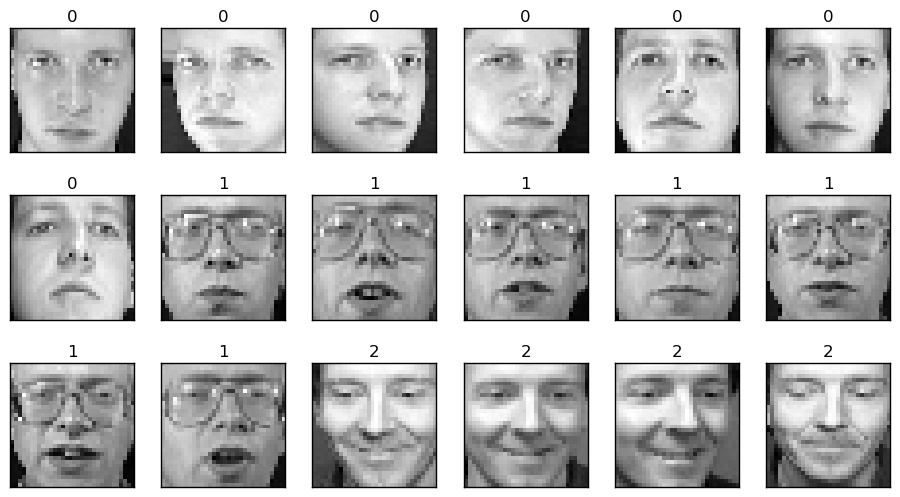

In [4]:
titles = [str(y[0]) for y in y_train]

plot_gallery(X_train, titles, image_h, image_w)

## Nearest Neighbour baseline

The simplest way to do face recognition is to treat raw pixels as features and perform **Nearest Neighbor Search** in the Euclidean space. Let's use **`KNeighborsClassifier`** class.

In [5]:
from sklearn.neighbors import KNeighborsClassifier

# Use KNeighborsClassifier to calculate test score for the Nearest Neighbour classifier.
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train)
test_score = knn_model.score(X_test, y_test)

print('Test score: {}'.format(test_score))

Test score: 0.891666666667


/home/anya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Not very imperssive, is it?

## Eigenfaces

All the dirty work will be done by the scikit-learn package. First we need to learn a dictionary of codewords. For that we preprocess the training set by making each face normalized (zero mean and unit variance)..

In [6]:
from sklearn.preprocessing import normalize

In [7]:
# Populate variable 'X_train_processed' with samples each of which has zero mean and unit variance.
X = np.concatenate([X_train, X_test], axis=0)
X = normalize(X)
X_train_processed = X[:X_train.shape[0]]
X_test_processed = X[X_train.shape[0]:]

/home/anya/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [8]:
assert len(X_train) == len(y_train)

Now we are going to apply **PCA** to obtain a dictionary of codewords. 
**`RamdomizedPCA`** class is what we need.

In [43]:
from sklearn.decomposition import PCA

n_components = 64
pca = PCA(svd_solver='randomized', n_components=n_components)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)
# Populate 'pca' with a trained instance of RamdomizedPCA.

We plot a bunch of principal components.

In [10]:
# Visualize principal components.

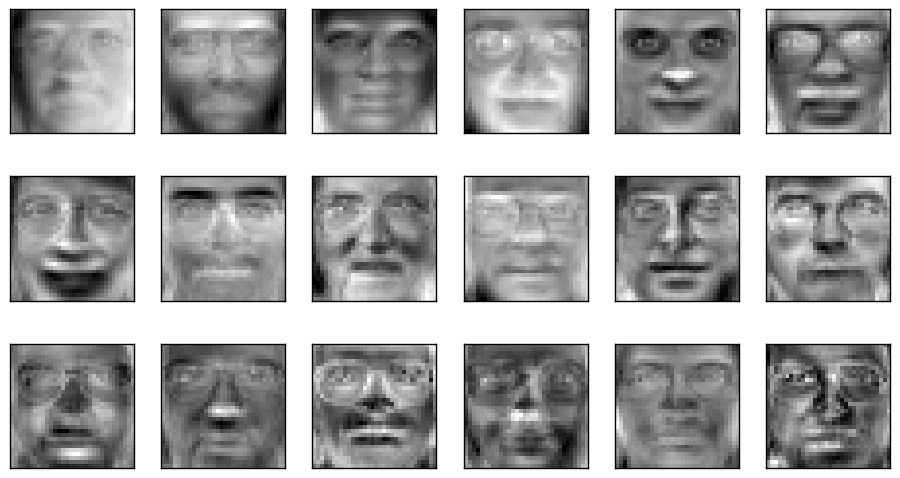

In [44]:
plot_gallery(pca.components_,[""] * len(pca.components_) , 32, 32)

This time we don't have any restriction on number of non-zero coefficients in the vector decomposition, so the codes are not sparse anymore:

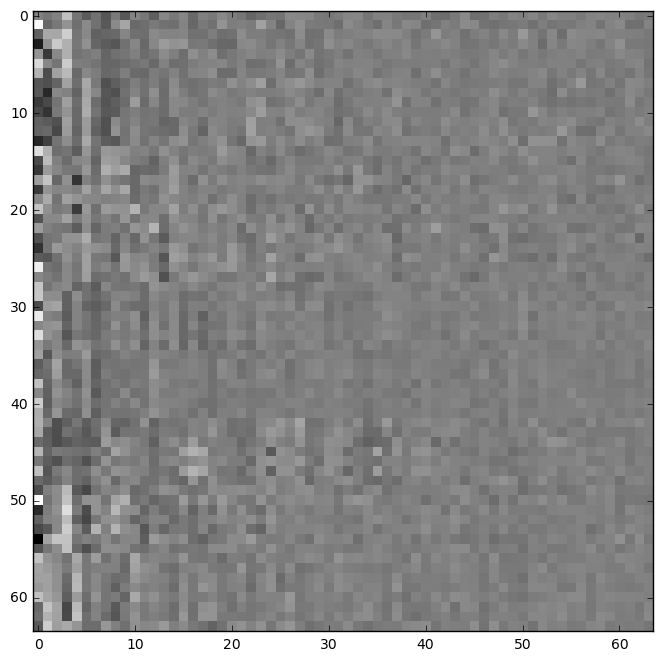

In [45]:
# Transform training data and plot decomposition coefficients.
plt.figure(figsize=(8,8))
plt.imshow(X_train_pca[:64,:], cmap=plt.cm.gray, interpolation='nearest')
plt.show()

Train an SVM and apply it to the encoded test data.

In [46]:
X_train_pca.shape, y_train.shape, X_test_pca.shape

((280, 64), (280, 1), (120, 64))

In [50]:
# Populate 'test_score' with test accuracy of an SVM classifier.
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score

param_grid = {'C' : [1, 10, 100, 500, 1000, 2000, 4000, 8000, 12000],
            'kernel': ['linear', 'rbf', 'poly']}
g_cv = GridSearchCV(SVC(), param_grid, n_jobs=-1)
g_cv.fit(X_train_pca, y_train.ravel())
test_score = g_cv.best_estimator_.score(X_test_pca, y_test)

print('Test score: {}'.format(test_score))
print("Best params ", g_cv.best_params_)

Test score: 0.925
('Best params ', {'kernel': 'linear', 'C': 500})


How many components are sufficient to reach the same accuracy level?

Max accuracy: 0.925


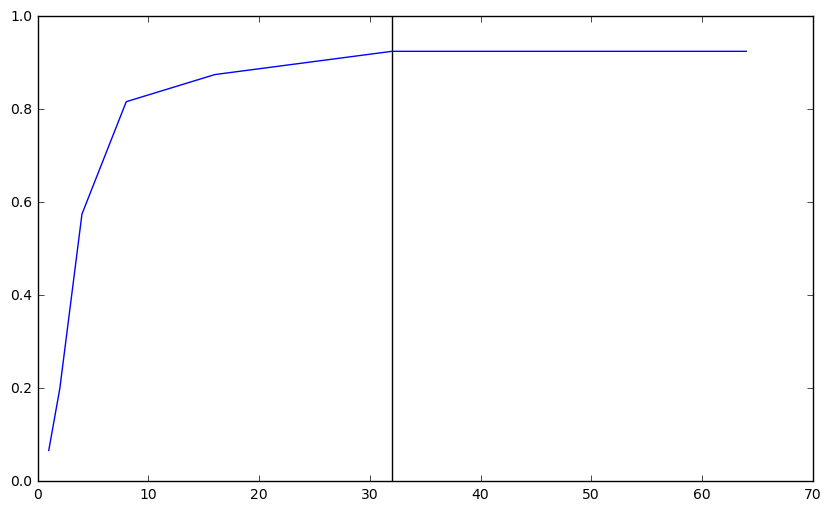

In [52]:
n_components = [1, 2, 4, 8, 16, 32, 64]
accuracy = []

# Try different numbers of components and populate 'accuracy' list.

for n_comp in n_components:
    pca = PCA(svd_solver='randomized', n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train_processed)
    X_test_pca = pca.transform(X_test_processed)
    
    g_cv = GridSearchCV(SVC(), param_grid, n_jobs=-1)
    g_cv.fit(X_train_pca, y_train.ravel())
    test_score = g_cv.best_estimator_.score(X_test_pca, y_test)
    
    #svm_model = SVC(kernel='linear', C=500)
    #svm_model.fit(X_train_pca, y_train)
    accuracy.append(test_score)
    
plt.figure(figsize=(10, 6))
plt.plot(n_components, accuracy)
plt.vlines(n_components[np.argmax(accuracy)], ymin=0, ymax=1.)

print('Max accuracy: {}'.format(max(accuracy)))

32 компоненты уже достаточно, чтобы превзойти бейзлайн с 1NN.